# Check Pre-Requisites

In [5]:
ingest_create_athena_table_csv_passed = False

In [6]:
%store -r ingest_create_athena_db_passed

In [7]:
try:
    ingest_create_athena_db_passed
except NameError:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS.  You did not create the Athena Database.")
    print("++++++++++++++++++++++++++++++++++++++++++++++")

In [8]:
print(ingest_create_athena_db_passed)

True


In [9]:
if not ingest_create_athena_db_passed:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS.  You did not create the Athena Database.")
    print("++++++++++++++++++++++++++++++++++++++++++++++")
else:
    print("[OK]")

[OK]


# Visualize Customer Order Dataset from Olist

In [2]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [4]:
# Set Athena parameters
    # database name
database_name = "olist"
    # table names
cust_table_name = "olist_customers_dataset"
order_items_table_name = "olist_order_items_dataset"
order_table_name = "olist_order_dataset"
products_table_name = "olist_products_dataset"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://ads-508-team4/athena/staging".format(bucket)

In [7]:
from pyathena import connect
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

# Set Seaborn Parameters

In [8]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars

In [9]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

## 1. What are the states of the customers come from

In [16]:
# customer dataset
cust_state = """
SELECT 
    customer_state,
    count(distinct customer_unique_id) cust_cnt
FROM {}.{}
group by customer_state
""".format(
    database_name, cust_table_name
)

cust_state = pd.read_sql(cust_state, conn)

In [30]:
cust_state = cust_state.sort_values(by=['cust_cnt'], ascending=False)

In [35]:
cust_state

,customer_state,cust_cnt
23,SP,40302
8,RJ,12384
14,MG,11259
1,RS,5277
0,PR,4882
9,SC,3534
4,BA,3277
24,DF,2075
19,ES,1964
10,GO,1952


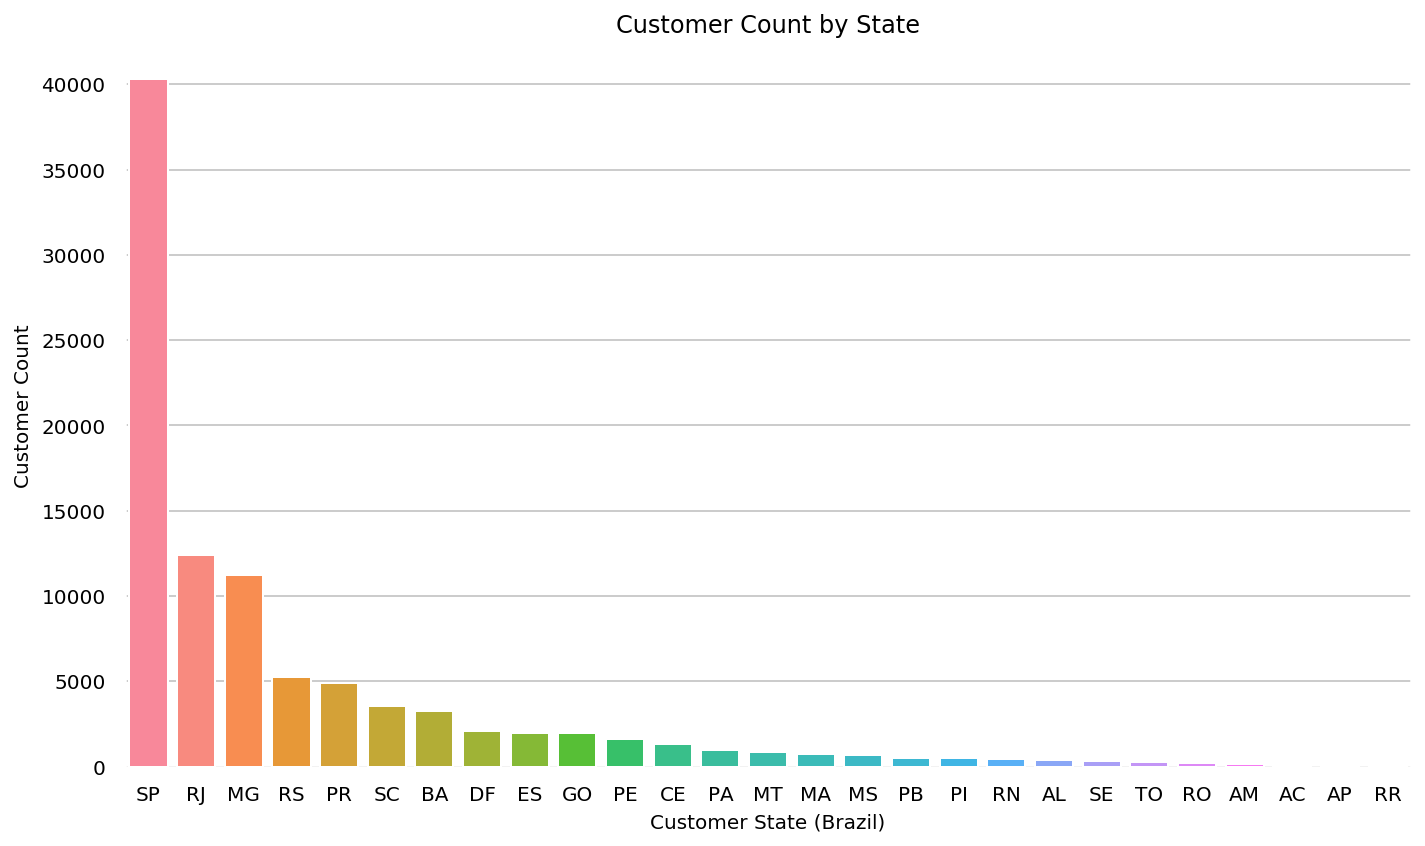

In [43]:
# Create plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(y="cust_cnt", x="customer_state", data=cust_state, saturation=1)

# Set title and x-axis ticks
plt.title("Customer Count by State")

plt.xlabel("Customer State (Brazil)")
plt.ylabel("Customer Count")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## 2. What are the top 20 cities of the customers come from

In [44]:
# customer dataset
cust_city = """
SELECT 
    customer_city,
    count(distinct customer_unique_id) cust_cnt
FROM {}.{}
group by customer_city
""".format(
    database_name, cust_table_name
)

cust_city = pd.read_sql(cust_city, conn)

In [49]:
cust_city = cust_city.sort_values(by=['cust_cnt'], ascending=False).head(15)
cust_city

,customer_city,cust_cnt
2026,sao paulo,14984
731,rio de janeiro,6620
257,belo horizonte,2672
2519,brasilia,2069
2025,curitiba,1465
743,campinas,1398
5,porto alegre,1326
733,salvador,1209
256,guarulhos,1153
2518,sao bernardo do campo,908


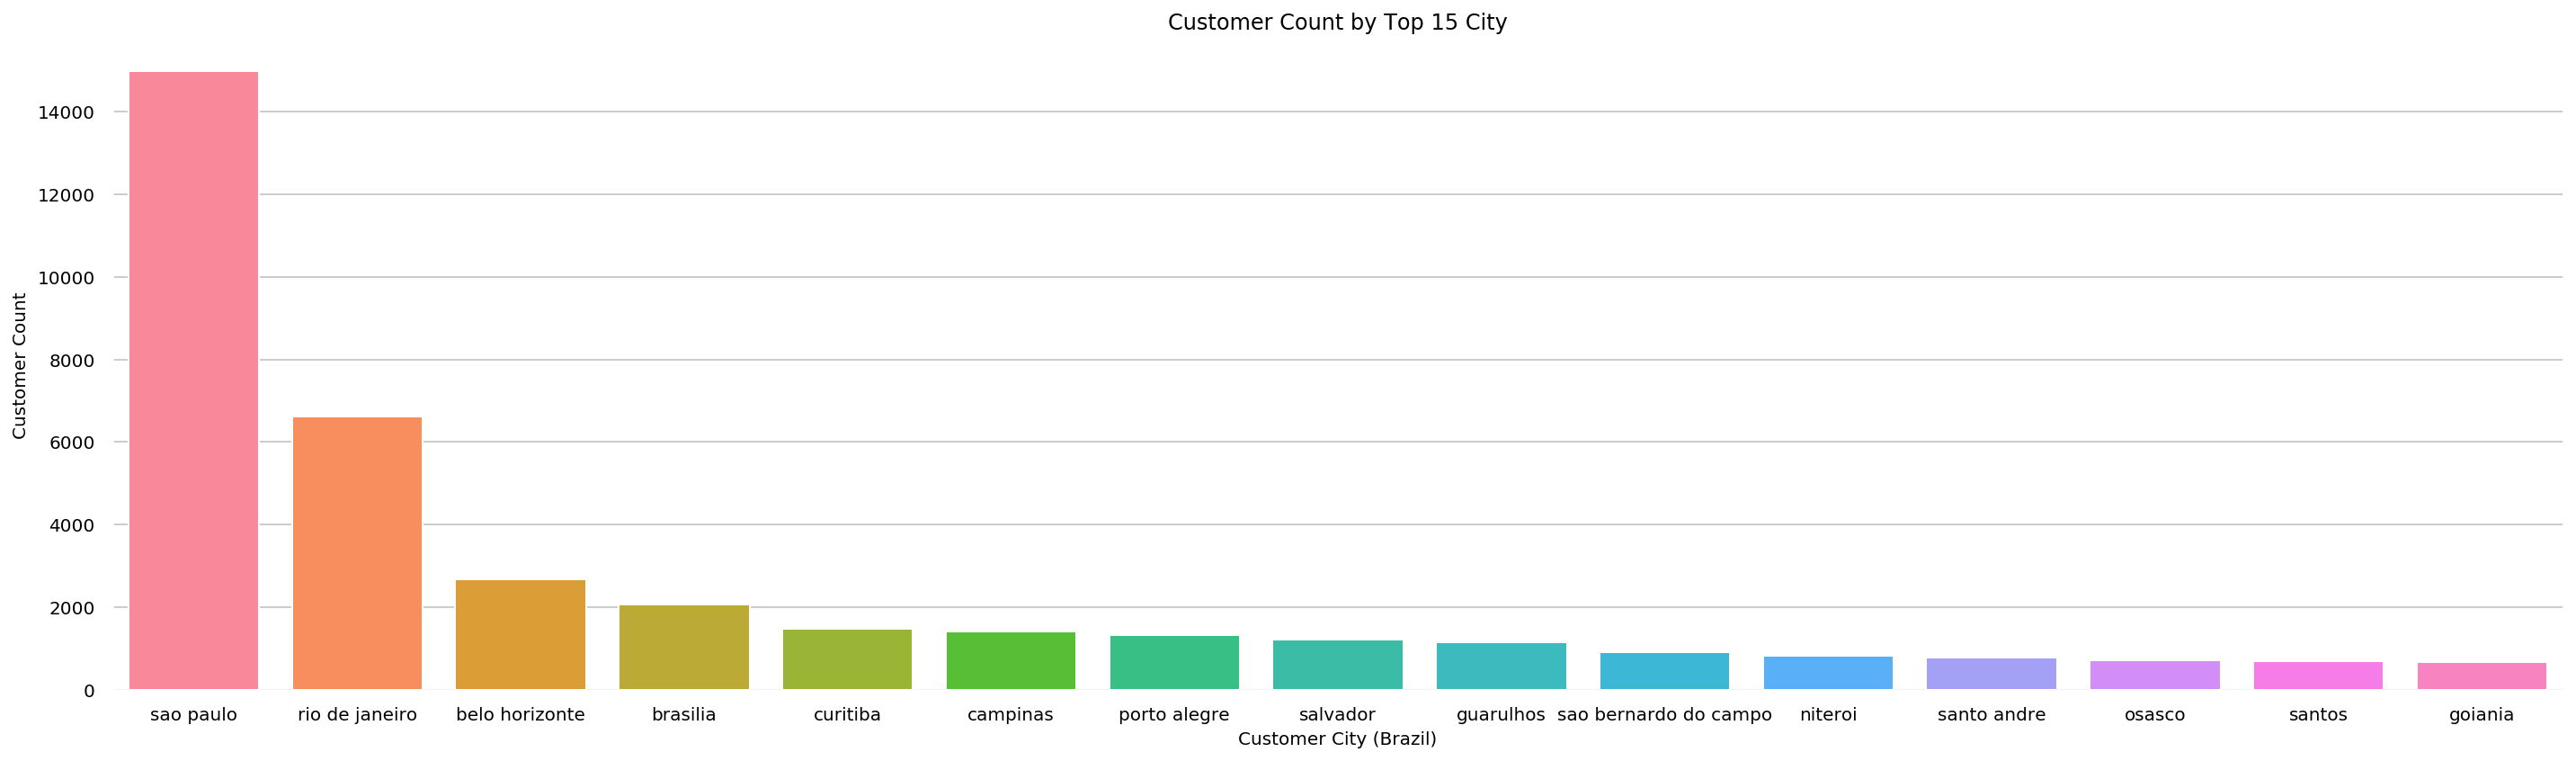

In [50]:
# Create plot
plt.figure(figsize=(20, 6))
barplot = sns.barplot(y="cust_cnt", x="customer_city", data=cust_city, saturation=1)

# Set title and x-axis ticks
plt.title("Customer Count by Top 15 City")

plt.xlabel("Customer City (Brazil)")
plt.ylabel("Customer Count")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## 3. Customer Overview

In [54]:
# customer dataset
cust_demo = """
SELECT 
    count(distinct customer_unique_id) cust_cnt,
    count(distinct customer_state) state_cnt,
    count(distinct customer_city) city_cnt
FROM {}.{}
""".format(
    database_name, cust_table_name
)

cust_demo = pd.read_sql(cust_demo, conn)

In [55]:
cust_demo

,cust_cnt,state_cnt,city_cnt
0,96096,27,4119


## 4. What are the top 10 of most popular products

In [58]:
# customer dataset
prod = """
SELECT 
    *
FROM olist.olist_order_items_dataset items
left join olist.olist_products_dataset prod on items.product_id = prod.product_id

"""

prod = pd.read_sql(prod, conn)

In [98]:
prod_agg = prod.groupby('product_category_name').agg({'order_id'          :  'count',
                                                      'price'             :  'mean',
                                                      'freight_value'     :  'mean',
                                                      'product_weight_g'  :  'mean' })
prod_agg = prod_agg.reset_index()

In [106]:
prod_agg.columns = ['product_category_name', 'order_cnt', 'avg_price', 'avg_freight_value', 'avg_product_weight_g']
prod_agg = prod_agg.sort_values(by='order_cnt', ascending=False)

In [114]:
prod_agg

,product_category_name,order_cnt,avg_price,avg_freight_value,avg_product_weight_g
14,cama_mesa_banho,11115,93.296327,18.415928,2116.753396
12,beleza_saude,9670,130.163531,18.879703,1048.766391
33,esporte_lazer,8641,114.344285,19.512500,1743.061567
55,moveis_decoracao,8334,87.564494,20.728258,2653.128870
45,informatica_acessorios,7827,116.513903,18.821781,902.509135
...,...,...,...,...,...
18,cds_dvds_musicais,14,52.142857,16.070714,550.000000
47,la_cuisine,14,146.785000,23.825000,3685.714286
61,pc_gamer,9,171.772222,14.841111,1882.777778
38,fashion_roupa_infanto_juvenil,8,71.231250,11.938750,265.000000


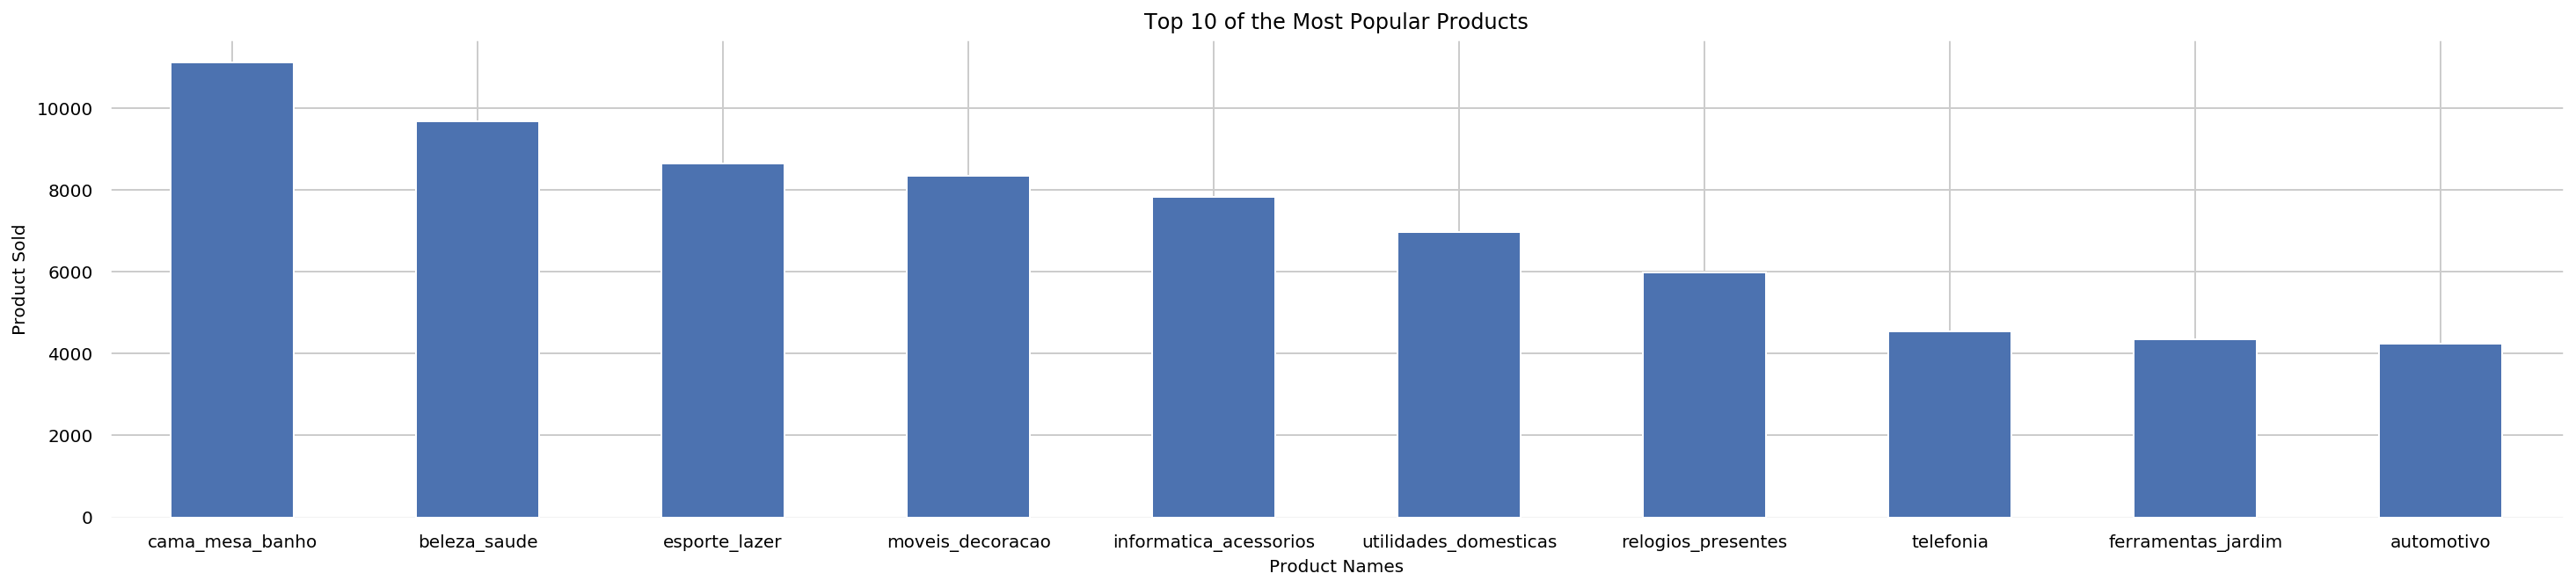

In [151]:
chart = prod_agg.head(10).plot.bar(
     x="product_category_name", y="order_cnt", rot="0", figsize=(25, 5), title="Top 10 of the Most Popular Products", legend=False)

plt.xlabel("Product Names")
plt.ylabel("Product Sold")

plt.show(chart)

## 5. What are the average prices for the top 10 of most popular products¶

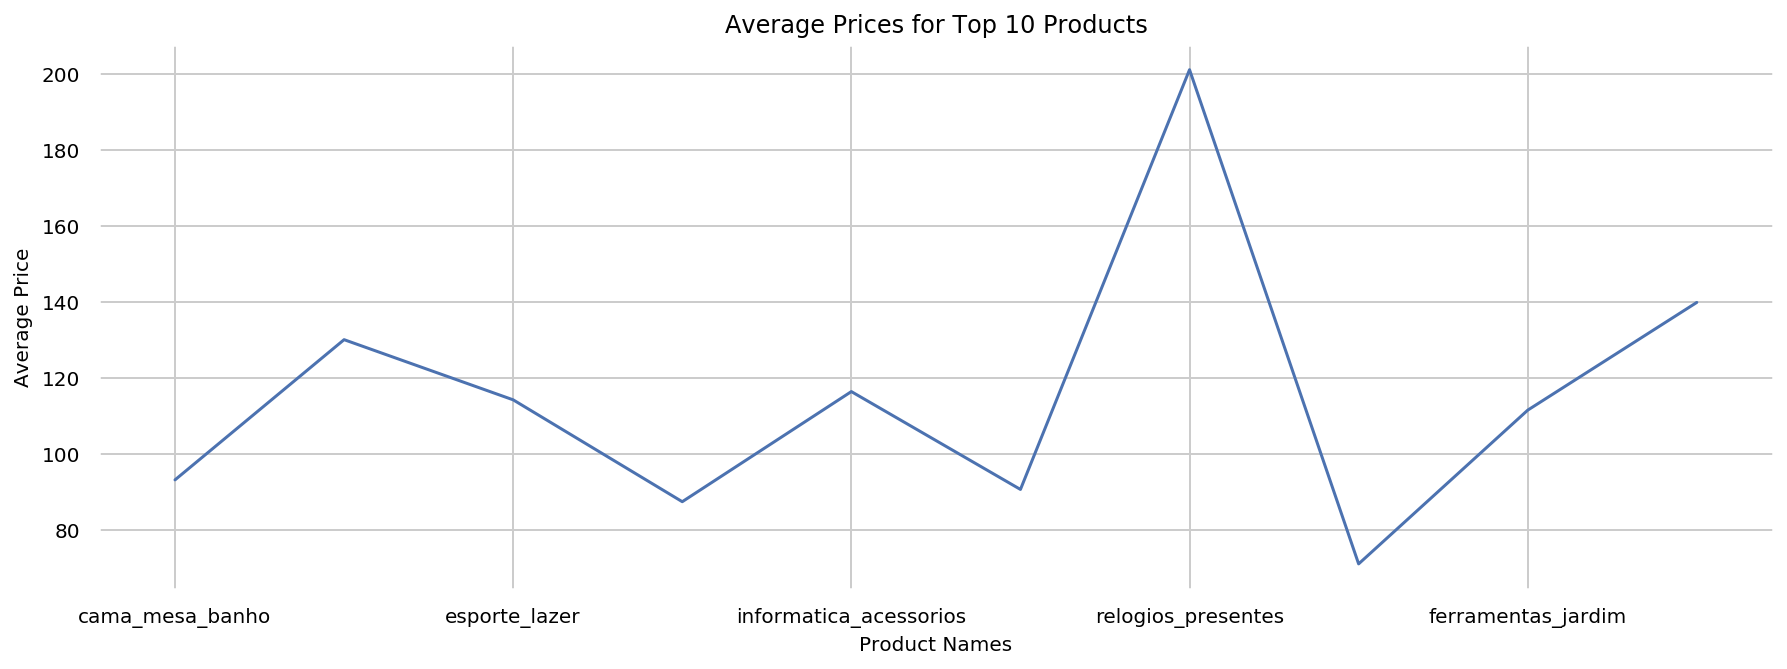

In [152]:
chart = prod_agg.head(10).plot.line(
     x="product_category_name", y="avg_price", rot="0", figsize=(15, 5), title="Average Prices for Top 10 Products", legend=False)

plt.xlabel("Product Names")
plt.ylabel("Average Price")

plt.show(chart)

## 6. Order Price Decile

In [162]:
decile_price = prod['price'].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
decile_price

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
10%          23.800000
20%          34.900000
30%          47.490000
40%          59.000000
50%          74.990000
60%          95.000000
70%         119.900000
80%         150.000000
90%         229.800000
100%       6735.000000
max        6735.000000
Name: price, dtype: float64

## 7. What are the average freight value for the top 10 of most popular products¶

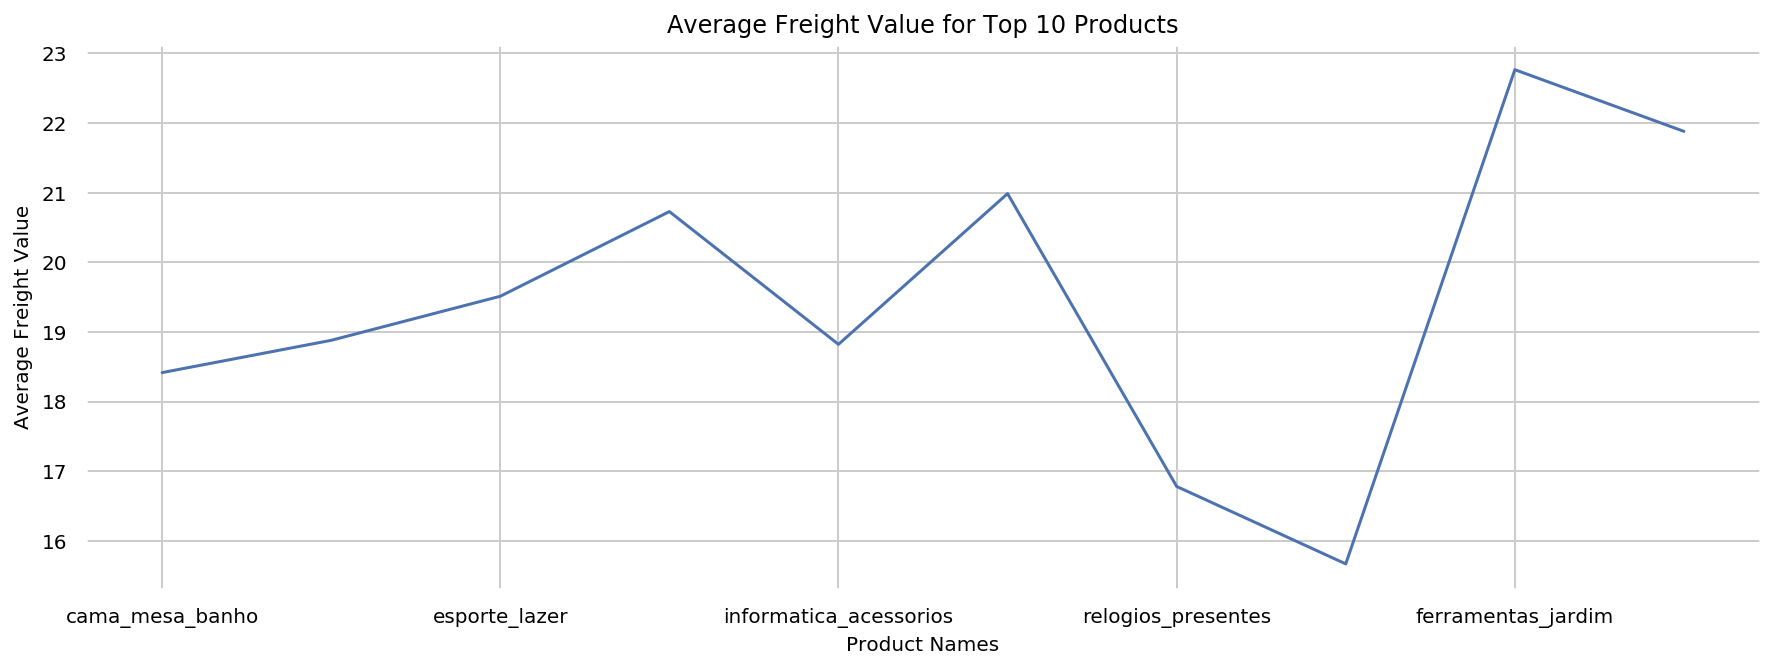

In [153]:
chart = prod_agg.head(10).plot.line(
     x="product_category_name", y="avg_freight_value", rot="0", figsize=(15, 5), title="Average Freight Value for Top 10 Products", legend=False)

plt.xlabel("Product Names")
plt.ylabel("Average Freight Value")

plt.show(chart)

## 8. Freight Value Decile

In [163]:
decile_freight = prod['freight_value'].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
decile_freight

count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
10%           8.730000
20%          12.120000
30%          14.020000
40%          15.110000
50%          16.260000
60%          17.870000
70%          19.410000
80%          23.280000
90%          34.041000
100%        409.680000
max         409.680000
Name: freight_value, dtype: float64

# Release Resources

In [165]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}